## Document classification for smart data solution

#### LayoutLM is a deep learning model developed by Microsoft Research Asia for document understanding tasks such as document layout analysis, information extraction, and document classification. The model is based on the popular BERT architecture and incorporates a region embedding layer to capture spatial information of the document layout.

## Installing dependencies

#### LayoutLM is a complex model architecture that involves multiple components such as visual feature extraction, text feature extraction, and positional encoding. <b>Detectron2</b> provides a convenient and efficient way to build and train custom models by offering pre-implemented building blocks for computer vision tasks, such as backbone networks and object detection heads.

In [1]:
#Used for fine-tuning the NLP task -- document classification, it provides useful tools for data loading, training and evaluation.
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-r19wxwoe
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-r19wxwoe
  Resolved https://github.com/facebookresearch/detectron2.git to commit d4a5f28e01b2babbaba9f90198fb95f5c661cccd
  Preparing metadata (setup.py) ... done


In [2]:
# Installing pytesseract to extract the texts in the images
!pip install pytesseract && pip install datasets && pip install transformers
! apt install tesseract-ocr
! apt install libtesseract-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [3]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import pytesseract
from PIL import Image, ImageDraw, ImageFont

import torch
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor, LayoutLMv2ForSequenceClassification, AdamW

### Loading the dataset
#### Dataset is uploaded in google drive for easy access.

In [4]:
dataset_path = "/content/drive/MyDrive/SDSfiles/imagesforcolab"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v:k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}

label2idx

{'0': 0, '4': 1, '9': 2, '2': 3, '6': 4}

In [5]:
# Defining the dataset using its path and label.
images = []
labels = []

for label in os.listdir(dataset_path):
    images.extend([
        f"{dataset_path}/{label}/{img_name}" for img_name in os.listdir(f"{dataset_path}/{label}")
    ])
    labels.extend([
        label for _ in range(len(os.listdir(f"{dataset_path}/{label}")))
    ])
data = pd.DataFrame({'image_path': images, 'label': labels})

# taking 60% of sample to training and 40% samples to testing
train_data, valid_data = train_test_split(data, test_size=0.40, random_state=0, stratify=data.label)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
print(f"{len(train_data)} training examples, {len(valid_data)} validation examples")
data.head()

120 training examples, 80 validation examples


,image_path,label
0,/content/drive/MyDrive/SDSfiles/imagesforcolab...,0
1,/content/drive/MyDrive/SDSfiles/imagesforcolab...,0
2,/content/drive/MyDrive/SDSfiles/imagesforcolab...,0
3,/content/drive/MyDrive/SDSfiles/imagesforcolab...,0
4,/content/drive/MyDrive/SDSfiles/imagesforcolab...,0


In [6]:
#Checking GPU unit prescence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Preparation

In [7]:
# This function takes an input dictionary of image paths and associated labels, 
# encodes them using a pre-trained Hugging Face transformer model via the `processor` object,
# and returns the encoded inputs and labels as a dictionary. The `Features` object defines 

def encode_training_example(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    encoded_inputs = processor(images, padding="max_length", truncation=True)
    encoded_inputs["labels"] = [label2idx[label] for label in examples["label"]]
    
    return encoded_inputs

training_features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(label2idx), names=list(label2idx.keys())),
})

In [8]:
# This function takes a Pandas DataFrame of image paths and associated labels, encodes them using the `encode_training_example` function,
# and returns a PyTorch dataloader that can be used to feed batches of encoded examples to a deep learning model during training. 

def training_dataloader_from_df(data):
    dataset = Dataset.from_pandas(data)
    
    encoded_dataset = dataset.map(
        encode_training_example, remove_columns=dataset.column_names, features=training_features, 
        batched=True, batch_size=2
    )
    encoded_dataset.set_format(type='torch', device=device)
    dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4, shuffle=True)
    batch = next(iter(dataloader))
    return dataloader

In [9]:
# initializes a feature extractor and a tokenizer for the LayoutLMv2 model, 
# and uses them to create a processor that can encode examples for use in 
# training a LayoutLMv2-based deep learning model

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

train_dataloader = training_dataloader_from_df(train_data)
valid_dataloader = training_dataloader_from_df(valid_data)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [10]:
# loading a pre-trained LayoutLMv2 model for sequence classification using the from_pretrained method from the Hugging Face Transformers library.
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",  num_labels=len(label2idx)
)
model.to(device);

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res2.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.12.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv1.norm.num_batches_

## Training

In [11]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    training_correct = 0
    #put the model in training mode
    model.train()
    for batch in tqdm(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        training_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        training_correct += (predictions == batch['labels']).float().sum()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])
    training_accuracy = 100 * training_correct / len(train_data)
    print("Training accuracy:", training_accuracy.item())  
        
    validation_loss = 0.0
    validation_correct = 0
    for batch in tqdm(valid_dataloader):
        outputs = model(**batch)
        loss = outputs.loss

        validation_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        validation_correct += (predictions == batch['labels']).float().sum()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])
    validation_accuracy = 100 * validation_correct / len(valid_data)
    print("Validation accuracy:", validation_accuracy.item()) 

Epoch: 0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 10.593567475676537
Training accuracy: 43.333335876464844


  0%|          | 0/20 [00:00<?, ?it/s]

Validation Loss: 5.547810509800911
Validation accuracy: 56.25
Epoch: 1


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 5.525776654481888
Training accuracy: 75.00000762939453


  0%|          | 0/20 [00:00<?, ?it/s]

Validation Loss: 3.9116818383336067
Validation accuracy: 75.0
Epoch: 2


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 2.9265794176608324
Training accuracy: 90.83333587646484


  0%|          | 0/20 [00:00<?, ?it/s]

Validation Loss: 3.0044865906238556
Validation accuracy: 80.0


In [12]:
# Saving the model
model.save_pretrained('saved_model/')

In [46]:
# loading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForSequenceClassification.from_pretrained("saved_model")
model.to(device);

## Testing

In [47]:
def testing_data(query):
  image = Image.open(query).convert("RGB")
  encoded_inputs = processor(image, return_tensors="pt").to(device)
  outputs = model(**encoded_inputs)
  preds = torch.softmax(outputs.logits, dim=1).tolist()[0]
  pred_labels = {label:pred for label, pred in zip(label2idx.keys(), preds)}
  print("likelyhood rates: ", pred_labels)
  max_key = max(pred_labels, key=pred_labels.get)
  print("The given image belong to class: ", max_key)
  return image

likelyhood rates:  {'0': 0.12071660161018372, '4': 0.6408048868179321, '9': 0.16886138916015625, '2': 0.012672482058405876, '6': 0.056944649666547775}
The given image belong to class:  4


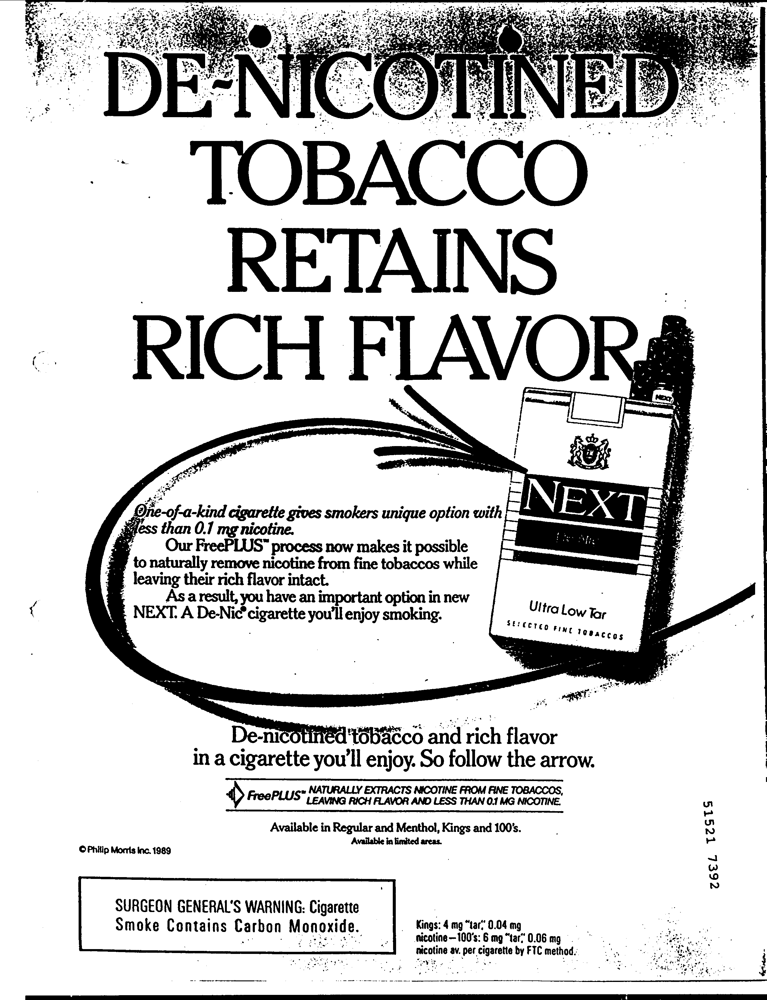

In [48]:
testing_data("/content/drive/MyDrive/testSDSfiles/data/test_image/4/001b7c4b-0cc4-4ec7-ab32-e2acd56385b4.TIF")

likelyhood rates:  {'0': 0.05784347653388977, '4': 0.021259283646941185, '9': 0.43512609601020813, '2': 0.4202482998371124, '6': 0.06552280485630035}
The given image belong to class:  9


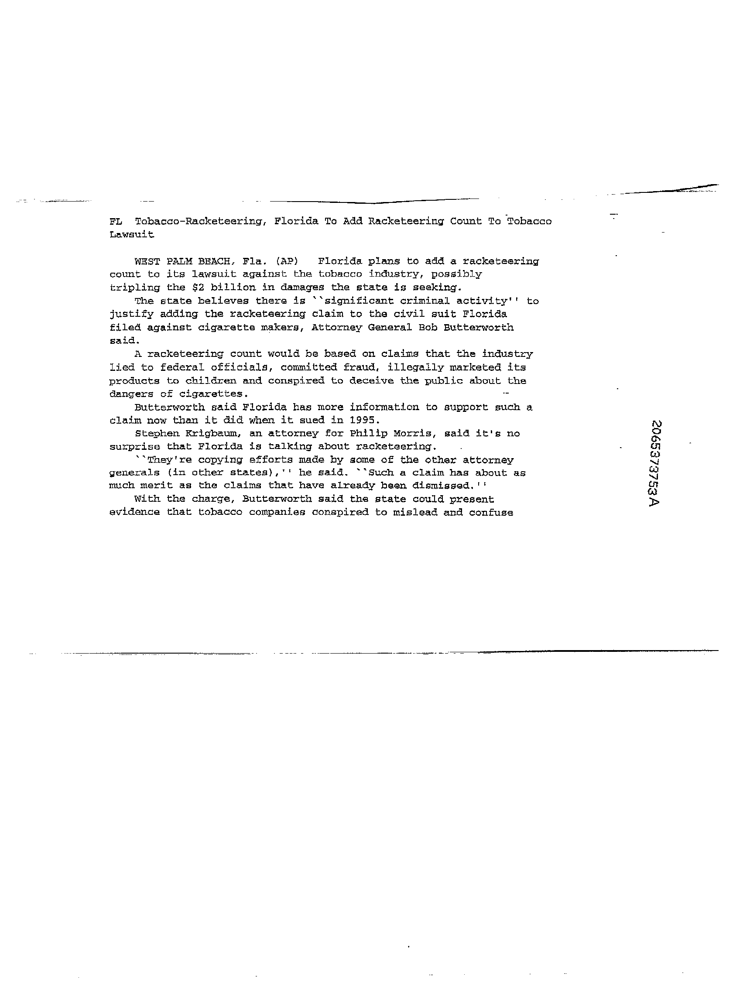

In [38]:
testing_data("/content/drive/MyDrive/testSDSfiles/data/test_image/9/0a4e5a19-d9fe-4599-a533-61ca14ca7fac.TIF")

likelyhood rates:  {'0': 0.009895622730255127, '4': 0.006048564799129963, '9': 0.006459713447839022, '2': 0.9731652140617371, '6': 0.004430927336215973}
The given image belong to class:  2


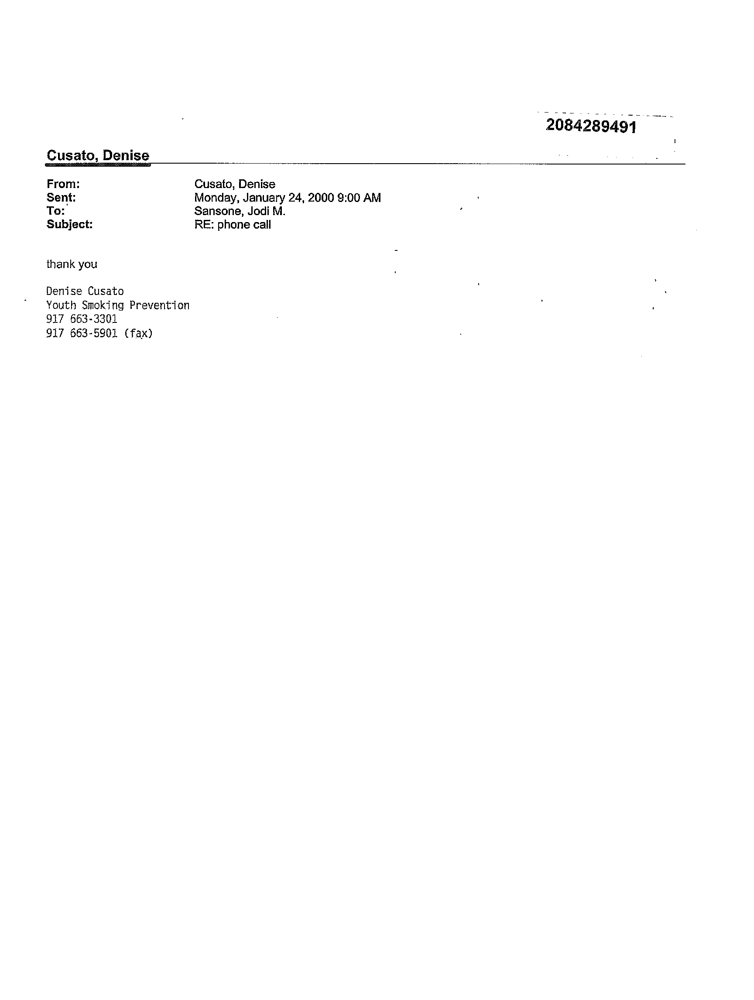

In [39]:
testing_data("/content/drive/MyDrive/testSDSfiles/data/test_image/2/00aecc1c-5538-46ac-900c-f9a7474fcdd1.TIF")

likelyhood rates:  {'0': 0.8974103927612305, '4': 0.00521860783919692, '9': 0.05120105668902397, '2': 0.009698734618723392, '6': 0.03647114709019661}
The given image belong to class:  0


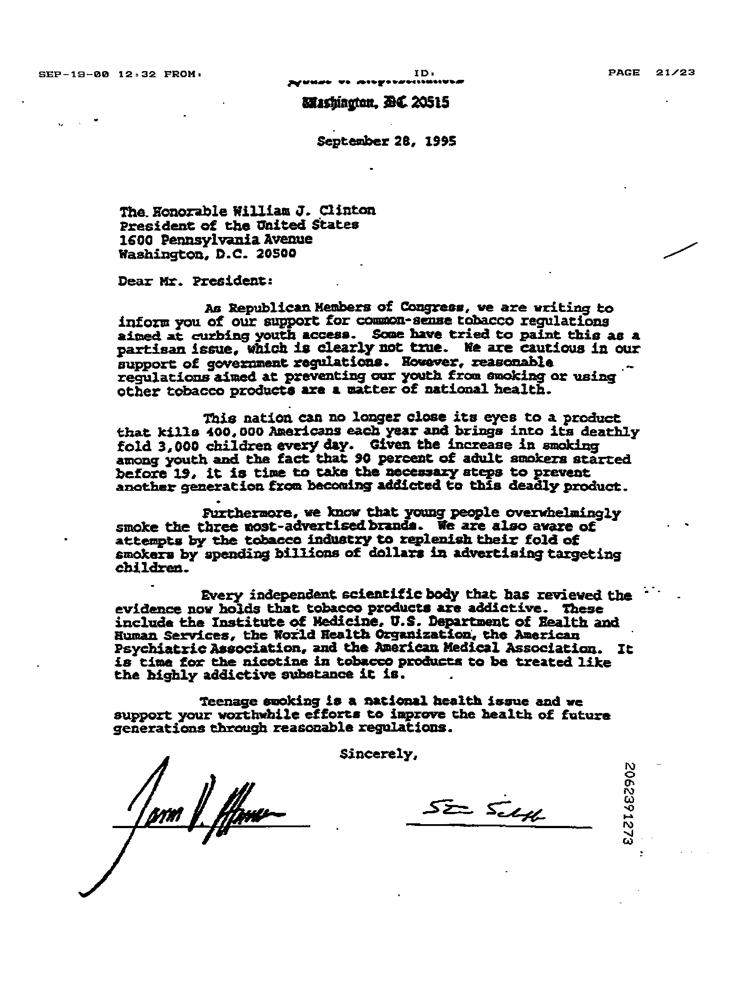

In [41]:
testing_data("/content/drive/MyDrive/testSDSfiles/data/test_image/0/00b8e9c9-76c8-431d-9584-16f37f13825c.TIF")

likelyhood rates:  {'0': 0.010507366620004177, '4': 0.14201374351978302, '9': 0.7907993197441101, '2': 0.011223853565752506, '6': 0.0454556979238987}
The given image belong to class:  9


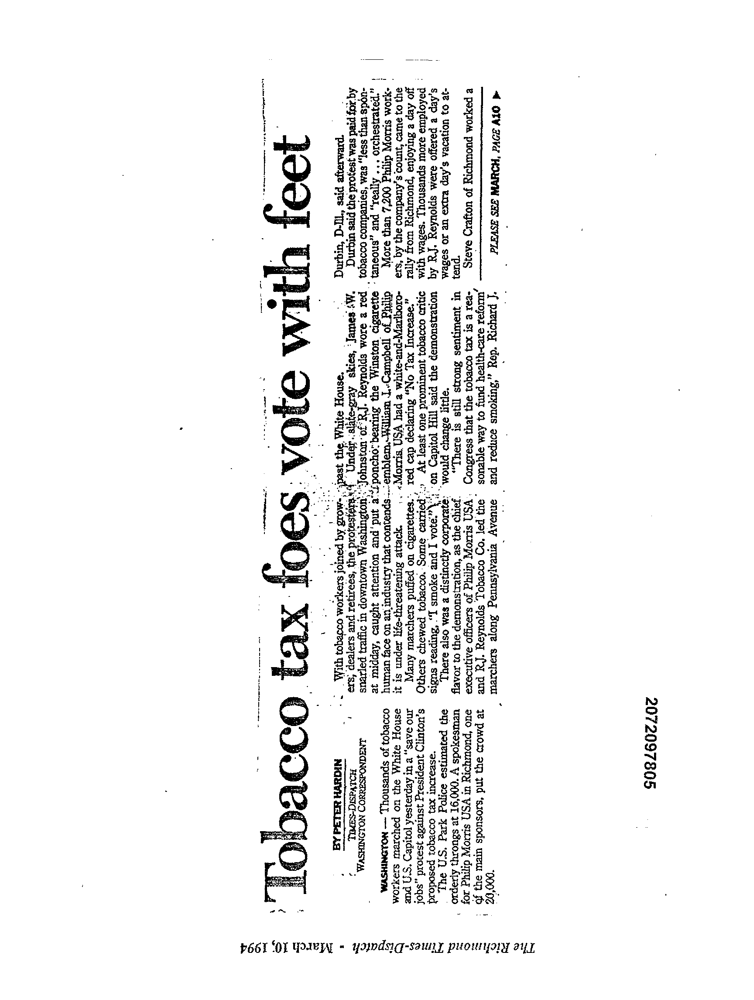

In [44]:
testing_data("/content/drive/MyDrive/testSDSfiles/data/test_image/9/0bfbfe7c-7102-40e3-bce5-99734d846a12.TIF")

In [17]:
#Downloading the model
!zip -r /content/file.zip /content/saved_model
from google.colab import files
files.download("/content/file.zip")

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/config.json (deflated 65%)
  adding: content/saved_model/pytorch_model.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

#### The model gave a promising results, from taking likely hood of being in a particular class and returning the highest rated result in the testing set. The model accuracy is 80 %.